# ResNet 만들기

ResNet은 15년도에 ImageNet Large Scale Visual Recognition Challenge (ILSVRC)  대회에서 우승한 모델이다.

이는 아주 깊은 층의 CNN 모델을 만들 수 있는 새로운 개념인 Residual network를 제안함으로 신경망 모델 구조 변화에 굉장히 큰 영향력을 선사하였다.

ResNet 신경망 모델을 이루는 중요한 개념은 크게 2가지이다.
1. residual network (skip connection) : 신경망이 깊어지며 생기는 기울기 전파 전달의 어려움을 아주 단순한 합 연산으로 해결
2. block network : CNN 구조를 block 단위로 구성함으로 보다 깊은 층의 효율적인 CNN 신경망 구조에 대해 제안되기 시작함



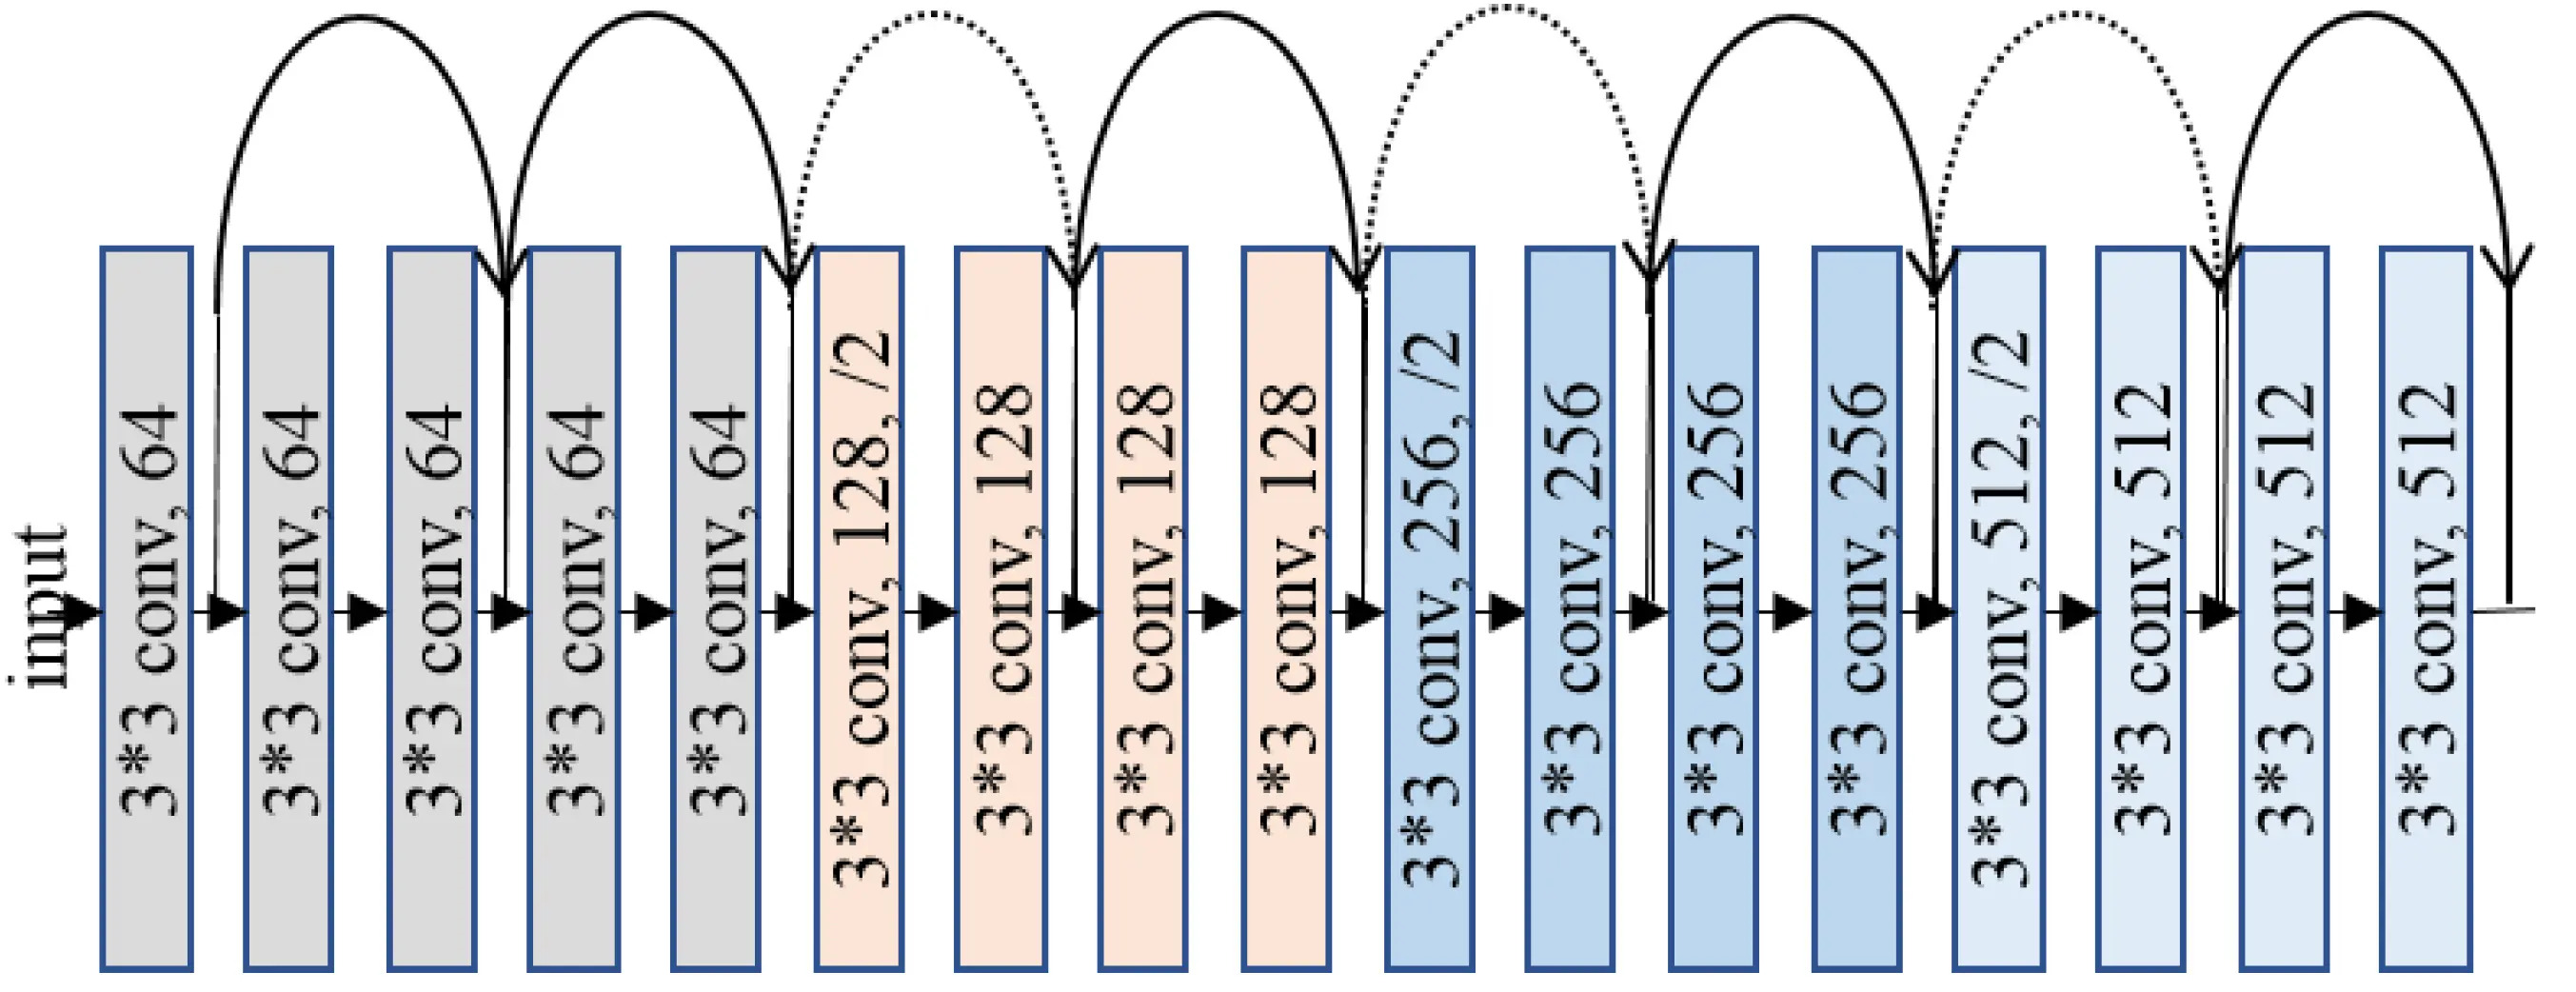

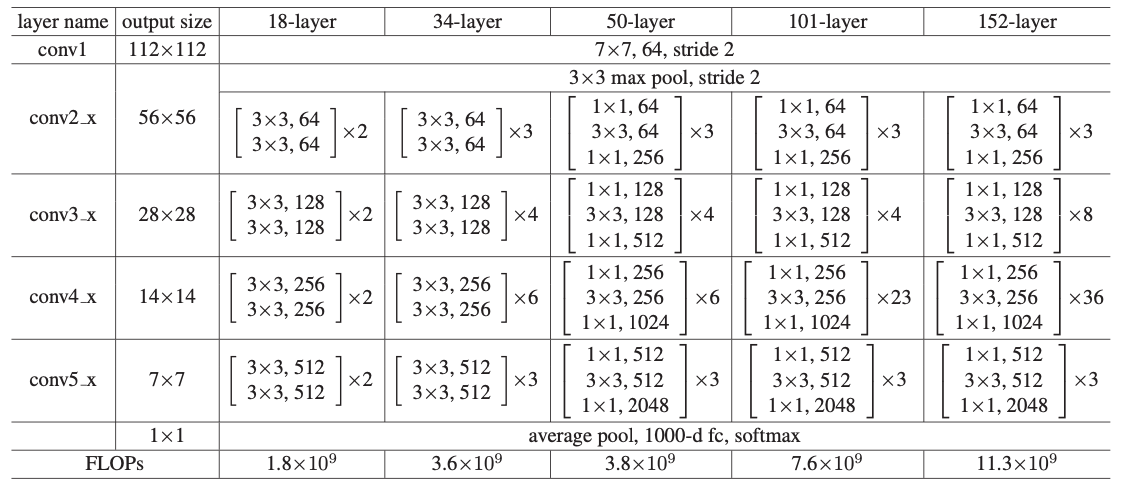

# 1. ResNet의 block 만들기

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1.1 basic block
- convolution layer가 2층 연결된 구조
- 각 블력별로 skip connection 이 존재해서 역전파 전달에 원활함을 도움

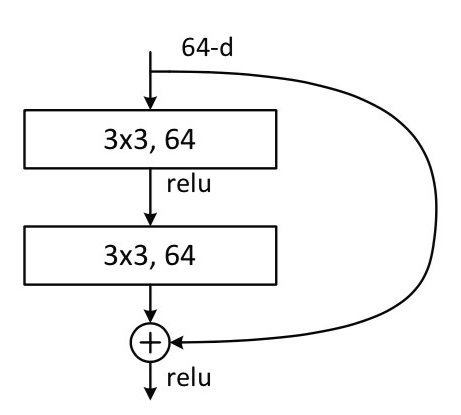

In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False) # 첫번째 convolution
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화 층
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # 두번째 convolution
        self.bn2 = nn.BatchNorm2d(planes)

        # skip connection
        self.shortcut = nn.Sequential()
        # 만약 convolution layer로 인해 channel size가 바뀌게 된다면 skip connection 을 위한 convolution layer 를 사용
        # 표 기준으로 layer name이 바뀔때
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

# 1.2 bottlenect module
- 1x1 크기의 필터만을 사용해서 channel 크기를 압축함으로 합성곱 계산 시 효율을 높임
- expansion => 채널 필터 압축 비율 설정
- 이를 통해 3층의 Convolution layer를 구성하지만 base model 보다 효율적인 FLOPs를 가짐

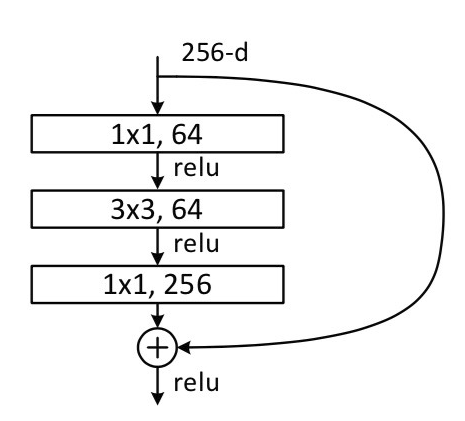

In [15]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        # 만약 convolution layer로 인해 channel size가 바뀌게 된다면 skip connection 을 위한 convolution layer 를 사용
        # 표 기준으로 layer name이 바뀔때
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

## 2.1 resnet 기본 골자 만들기
- resnet은 기본적으로 VGG-19 모델 구조를 차용함.
- 그렇기에 총 5부분의 신경망 층 섹션을 나눔 (channel 크기 기준)
- 이떄 각 섹션별로 사용되는 블록 개수에 따라 resnet 모델의 총 Convolution 층의 개수가 달라짐.
- 마지막 출력에 해당하는 층에서는 avg pooling 을 통해 입력 크기 사이즈를 줄임.
- pooling 대신 stride를 2로 함으로 입력 데이터 크기를 줄여나감.

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 가중치 초기화 설정 (논문 참조)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # 가중치 초기화 설정 (논문 참조)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out

In [17]:
def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)

In [18]:
model_dict = {
    'resnet18': [resnet18, 512],
    'resnet34': [resnet34, 512],
    'resnet50': [resnet50, 2048],
    'resnet101': [resnet101, 2048],
}

In [19]:
class ResNetModel(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128):
        super(ResNetModel, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetModel(name='resnet18', head='mlp', feat_dim=128).to(device)

In [21]:
!pip install torchsummary
from torchsummary import summary

In [22]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,864
       BatchNorm2d-4         [-1, 64, 224, 224]             128
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
        BasicBlock-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
       BasicBlock-12         [-1, 64, 224, 224]               0
           Conv2d-13        [-1, 128, 112, 112]          73,728
      BatchNorm2d-14        [-1, 128, 1

In [23]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

torch.Size([3, 32, 32])
6
Epoch [1/10], Train Loss: 3.6690, Val Loss: 3.5612
Epoch [2/10], Train Loss: 3.5241, Val Loss: 3.4719
Epoch [3/10], Train Loss: 3.4565, Val Loss: 3.4274
Epoch [4/10], Train Loss: 3.4133, Val Loss: 3.3960
Epoch [5/10], Train Loss: 3.3828, Val Loss: 3.3755
Epoch [6/10], Train Loss: 3.3625, Val Loss: 3.3914
Epoch [7/10], Train Loss: 3.3467, Val Loss: 3.3375
Epoch [8/10], Train Loss: 3.3319, Val Loss: 3.3214
Epoch [9/10], Train Loss: 3.3204, Val Loss: 3.3142
Epoch [10/10], Train Loss: 3.3118, Val Loss: 3.3071
Test Accuracy: 85.17%


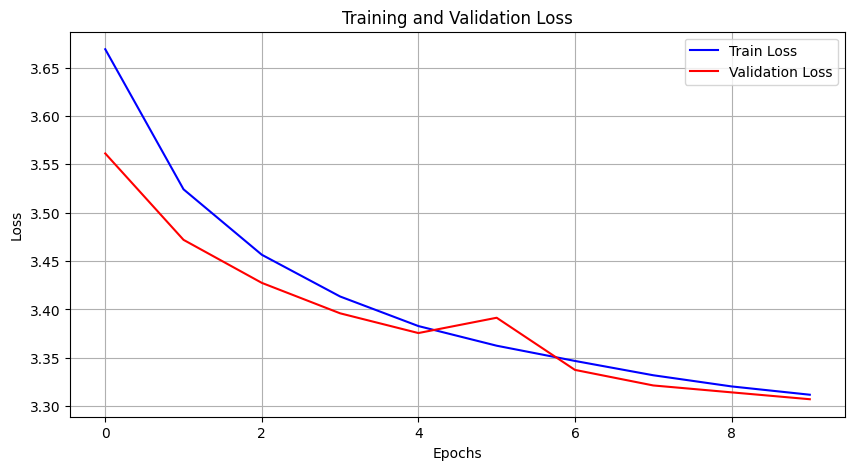

In [24]:
import torchvision
from torchvision import transforms


# data augmentation for image
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# MNIST 데이터 로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train,  download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',  transform=transform_test, train=False)

# 데이터 로더
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# 하이퍼파라미터 설정
feature_dim = 64 # 마지막 은닉층 유닛 수
num_classes = 10 # 물체 이미지 분류
learning_rate = 1e-3

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetModel(name='resnet18', head='mlp', feat_dim=feature_dim).to(device)

# 손실 함수와 옵티마이져 설정하기
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 손실 기록 리스트
train_losses = []
val_losses = []

# 학습 루프
num_epochs = 10

# 학습
for epoch in range(num_epochs):
    model.train() # 학습을 알리는 flag
    running_loss = 0.0 # epoch 마다 평균 loss값 측정

    for images, labels in train_loader:
        images = images.to(device) # (batch, 3, 32, 32)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # 검증
    model.eval() # 을 알리는 flag
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) # (batch, 3, 32, 32)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


# 테스트셋을 이용해 모델의 정확도 평가하기
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader: # 테스트 데이터 불러오기
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) # 학습된 모델로부터 테스트 데이터의 예측 값 얻기
        _, predicted = torch.max(outputs.data, 1) # 가장 확률이 높은 숫자 값 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%') # 테스트 데이터셋의 전체 정확도

# 손실값 시각화
plot_losses(train_losses, val_losses)